In [1]:
import numpy as np
import matplotlib.pyplot as plt
from visanalysis.analysis import imaging_data, shared_analysis
import os
from scipy import interpolate
from two_photon_analysis.medulla_analysis import getAltEpochResponseMatrix

In [10]:
# Define some convenience functions
def getRandVal(rand_min, rand_max, start_seed, update_rate, t):
  seed = int(round(start_seed + t*update_rate))
  np.random.seed(seed)
  return np.random.choice([rand_min, (rand_min + rand_max)/2, rand_max], size=1)[0]

def getFilter(ID, epoch_inds, stimulus_start_times, filter_length, ideal_frame_rate):
  filter_len = filter_length * ideal_frame_rate
  
  stim_frames = ID.getRunParameters('stim_time') * ideal_frame_rate
  
  # TMP
  stim_frames = int(stim_frames / 3)
  # TMP
  
  # frame flip times in a stimulus presentation:
  stim_times = np.arange(1, stim_frames+1) * 1/ideal_frame_rate

  all_trfs = []
  for epoch_ind in epoch_inds:
    # Regenerate the stimulus
    start_seed = epoch_parameters[epoch_ind]['start_seed']
    rand_min = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_min']
    rand_max = eval(epoch_parameters[epoch_ind]['distribution_data'])['kwargs']['rand_max']
    update_rate = epoch_parameters[epoch_ind]['update_rate']

    new_stim = np.array([getRandVal(rand_min, rand_max, start_seed, update_rate, t) for t in stim_times])
    current_frame_times = stimulus_start_times[epoch_ind] + stim_times  # In Prairie View time (sec)

    baseline_time = 1 # (sec) generally could be pre_time, but for opto only take previous 1 sec
    baseline_times = np.linspace(current_frame_times[0]-baseline_time, current_frame_times[0], int(1/sample_period))
    baseline = np.mean(f_interp_response(baseline_times))

    # Convert to dF/F
#     current_interp_response = (f_interp_response(current_frame_times) - baseline) / baseline
    
    current_interp_response = f_interp_response(current_frame_times)

    filter_fft = np.fft.fft(current_interp_response - np.mean(current_interp_response)) * np.conj(
        np.fft.fft(new_stim - np.mean(new_stim)))

    filt = np.real(np.fft.ifft(filter_fft))[0 : int(filter_len)]

    trf = np.flip(filt)
    all_trfs.append(trf)

  all_trfs = np.stack(all_trfs, axis=-1)
  
  filter_time = np.flip(np.arange(0, filter_len) * 1/ideal_frame_rate) # sec
  filter_mean = np.mean(all_trfs, axis=-1)
  
  return filter_time, filter_mean


Found 1 files in /Users/mhturner/CurrentData/avery
Found 3 matching series


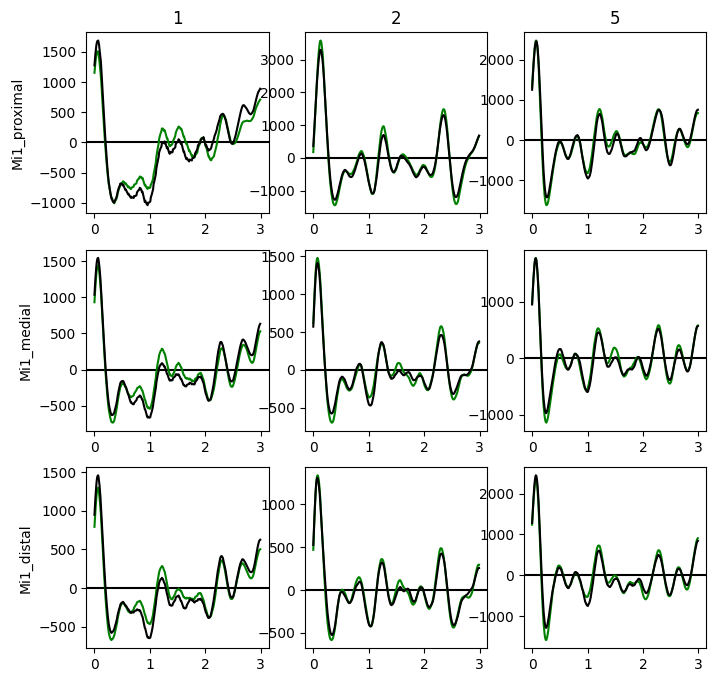

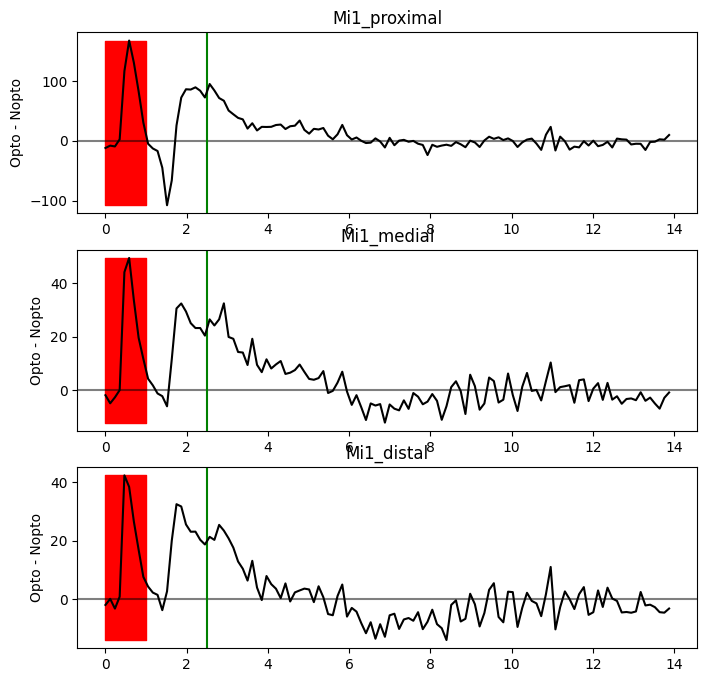

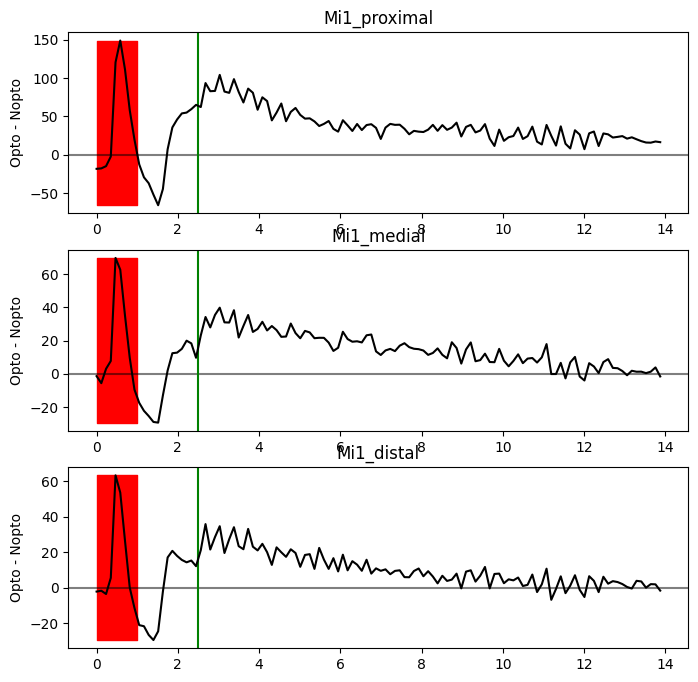

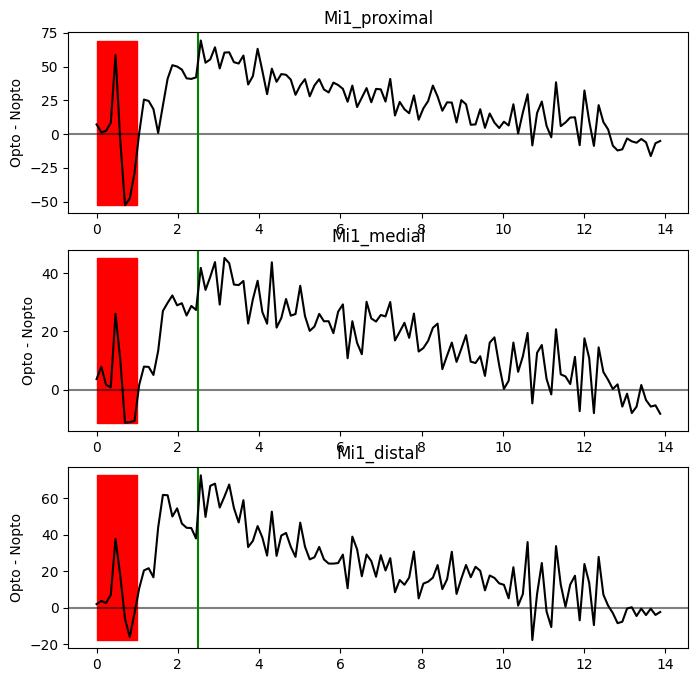

In [14]:
experiment_file_directory = '/Users/mhturner/CurrentData/avery'

ideal_frame_rate = 120 # Hz
filter_length = 3 # sec
roi_names = ['Mi1_proximal', 'Mi1_medial', 'Mi1_distal']


matching_series = shared_analysis.filterDataFiles(data_directory=experiment_file_directory,
                                                target_series_metadata={'protocol_ID': 'WhiteNoiseWithOpto',
                                                                        },
                                                target_roi_series=roi_names,
                                                )

fh1, ax1 = plt.subplots(len(roi_names), len(matching_series), figsize=(8, 8))
for s_ind, series in enumerate(matching_series):
  fh, ax = plt.subplots(len(roi_names), 1, figsize=(8, 8))
  ID = imaging_data.ImagingDataObject(series['file_name'] + '.hdf5',
                                      series['series'],
                                      quiet=True)
  
  # Get stim timing for this series
  epoch_parameters = ID.getEpochParameters()
  sample_period = ID.getAcquisitionMetadata('sample_period') # (sec), bruker imaging acquisition period
  stimulus_timing = ID.getStimulusTiming(plot_trace_flag=False)
  stimulus_start_times = stimulus_timing['stimulus_start_times']
  
  
  for r_ind, roi_name in enumerate(roi_names):
    # Get roi data
    roi_data = ID.getRoiResponses(roi_name, return_erm=False)
    # Single roi set, single roi
    roi_ind = 0
    response_trace = roi_data.get('roi_response')[roi_ind][0, :]
    response_time = np.arange(1, len(response_trace)+1) * ID.getAcquisitionMetadata('sample_period')
    # Interpolation function to interpolate response. Fxn built using sample period
    f_interp_response = interpolate.interp1d(response_time, response_trace)
    
    time_vec, erm = getAltEpochResponseMatrix(ID, 
                                              roi_data.get('roi_response')[0], 
                                              alt_pre_time=0, 
                                              dff=False, 
                                              df=False)
    
    # Opto trials
    opto_trials, opto_inds = shared_analysis.filterTrials(erm, 
                                                          ID, 
                                                          query={'opto_stim': True}, 
                                                          return_inds=True)
    filter_time, filter_opto = getFilter(ID, 
                                         epoch_inds=opto_inds, 
                                         stimulus_start_times=stimulus_start_times,
                                         filter_length=filter_length, 
                                         ideal_frame_rate=ideal_frame_rate)
    
    # No opto trials
    nopto_trials, nopto_inds = shared_analysis.filterTrials(erm, 
                                                            ID, 
                                                            query={'opto_stim': False}, 
                                                            return_inds=True)
    filter_time, filter_nopto = getFilter(ID, 
                                          epoch_inds=nopto_inds, 
                                          stimulus_start_times=stimulus_start_times,
                                          filter_length=filter_length, 
                                          ideal_frame_rate=ideal_frame_rate)
    
    ax1[r_ind, s_ind].axhline(y=0, color='k')
    ax1[r_ind, s_ind].plot(filter_time, filter_opto, 'g')
    ax1[r_ind, s_ind].plot(filter_time, filter_nopto, 'k')
    if s_ind == 0:
      ax1[r_ind, s_ind].set_ylabel(roi_name)
    if r_ind == 0:
      ax1[r_ind, s_ind].set_title(series['series'])
      
    diff = opto_trials - nopto_trials  # difference of subsequent trials (same seed)
    ax[r_ind].axhline(y=0, color='k', alpha=0.5)
    ax[r_ind].axvline(x=2+0.5, color='g')
    ax[r_ind].fill_betweenx(y=[np.mean(diff, axis=(0, 1)).max(), np.mean(diff, axis=(0, 1)).min()],
                            x1=0,
                            x2=1,
                            color='r')
    # Plot mean across all (paired) trial differences
    ax[r_ind].plot(time_vec, np.mean(diff, axis=(0, 1)), 'k')
    ax[r_ind].set_ylabel('Opto - Nopto')
    
    ax[r_ind].set_title(roi_name)
    

    

In [7]:
diff = opto_trials - nopto_trials
diff.shape


(1, 75, 120)